# Covid Survival in Mexico Analysis

**What was done:**


1.   *Business Understanding*: 
  - understand the goal of this work and why it is important. (Section I)
2.   *Data Understanding*: 
  - Explore the dataset and column by column
  - Make sure that the data contained is correctly interpreted (eg. translating column names, finding the correct description of the columns on the official website on github, searching for papers to have a wider view of the work) (Section II)
3. *Data Preparation*: (Section III)
 - clean
 - filter
 - prepare data for further steps. 

  In this part of the looked more closely to errors, inconsistencies, and various type of problems that data in columns could have had and that could prevent our model from learning accurately. <br>
  In particular:
  - remove the un-necessary columns (the id created when inserting a new observation into the register and the date in which the new observation was inserted).
  - remove null values
  - convert categorical data to numerical
  - remove outliers (for example age 120 in the column 'EDAD')
  - normalize (min-max normalization) every column so that the model could not be biased from a different choice of range in the data
  - remove redundant column (using the pearson correlation between one another)
  - feature selection using PCA to reduce the number of columns and avoid falling into the *curse of dimensionality* problem. 


**What still needs to be done**:

3. *Data Preparation* (Section III): 
  -  This dataset is also unbalanced so we will study the best techniques to balance it and apply them to the dataset.


4. *Modelling* (Section IV)
  - Our goal for this section will be to train different models using cross-validation. Also, we want to see if the model performs better with or without feature selection. If we realise that the performance are lower after PCA, we shall search for other types of feature selection or try without. <br>
  - Another goal that we will like to achieve is to perform hyperparameter tuning on the best models and find out if the models could be tuned to obtain better results. <br>
  - We balanced our dataset in the previous section but other experiments could be executed on the model directly instead of the dataset: for example by applying weigths to each class. We will analyze this possibility.


5. *Evaluation* (Section V)
In this part we shall evaluate each model. Different metrics will be considered.


6. *Conclusion* (Section VI)
This part will conclude our work by discussing the techniques used and the various approaches studied.

# 1. Business Understanding

### **1.1 - Background**

After three years of pandemic, all the world knows about COVID19, a virus that causes severe acute respiratory syndrome (SARS-CoV-2). Over 106 million SARS-CoV-2 infections and over 2.3 million fatalities have been reported as of the first week of February 2021. This epidemic has severely disrupted global economic activity. 
In response to the worldwide public health crisis, scientists and physicians have worked very hard to give new insights and develop technology solutions that may assist in combating this infectious sickness and lessening its effects. <br>
<br>
Artificial intelligence approaches have been recognized in this context as a potent and promising technology that may help with:
<ul>
    <li>the diagnostic process</li>
    <li>prediction of disease spreading dynamics</li>
    <li>tracking of infected patients</li>
    <li> tracking of potential future patients</li>
    <li> determine if a particular patient poses a mortality risk</li>
</ul>

### **1.2 - Business Objectives**
In this scenario is important to improve hospital capacity planning and ensure that the right patient receive timely treatment.

### **1.3 - Business Success Criteria**
The business success criterias are met if health care priorities are currenty assigned and identify high-risk patients are quickly identified.

### **1.4 - Situation**
To our disposal we have a dataset containing 4 million entries of 40 attributes, each one containing information about a patient 


### **1.5 - Data Mining Goals**
Correctly identify patients who are more likely to die and patients who are more likely to survive.

### **1.6 - Data Mining Success Criteria**
The success criteria are satisfied if the model is able to identify patient with high precision in a fast way.

# 2. Data Understanding

### **2.1 - Initial Data Collection**

In [5]:
%%capture 
%pip install shap
%pip install category_encoders
%pip install imblearn

In [6]:
# libraries import
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from sklearn import preprocessing
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn.impute import SimpleImputer
from pandas.api.types import is_numeric_dtype
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn import linear_model
from scipy import stats
from sklearn.decomposition import PCA
import seaborn as sns
from sklearn.feature_selection import RFE
import statsmodels.api as sm
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.inspection import permutation_importance
import shap
import category_encoders as ce
from sklearn.ensemble import GradientBoostingRegressor

from sklearn.naive_bayes import BernoulliNB
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.utils import compute_class_weight

from sklearn.model_selection import cross_validate
from sklearn.model_selection import cross_val_predict

from sklearn.model_selection import RepeatedStratifiedKFold
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import BorderlineSMOTE
from collections import Counter

from statistics import mean

sns.set_style("darkgrid")
sns.set_palette("Set2")

In [ ]:
path  = "./dataset"

In [7]:
from google.colab import drive
drive.mount('/content/drive')
path = "/content/drive/MyDrive/IDS"
df = pd.read_csv(path + "/COVID19MEXICO2020.csv")

Mounted at /content/drive


In [8]:
df = pd.read_csv(path + "/COVID19MEXICO2020.csv")

In [ ]:
print(f"Data has {df.shape[0]} rows and {df.shape[1]} attributes")

Data has 3779640 rows and 40 attributes


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3779640 entries, 1 to 3779640
Data columns (total 40 columns):
 #   Column                 Dtype 
---  ------                 ----- 
 0   FECHA_ACTUALIZACION    object
 1   ID_REGISTRO            object
 2   ORIGEN                 int64 
 3   SECTOR                 int64 
 4   ENTIDAD_UM             int64 
 5   SEXO                   int64 
 6   ENTIDAD_NAC            int64 
 7   ENTIDAD_RES            int64 
 8   MUNICIPIO_RES          int64 
 9   TIPO_PACIENTE          int64 
 10  FECHA_INGRESO          object
 11  FECHA_SINTOMAS         object
 12  FECHA_DEF              object
 13  INTUBADO               int64 
 14  NEUMONIA               int64 
 15  EDAD                   int64 
 16  NACIONALIDAD           int64 
 17  EMBARAZO               int64 
 18  HABLA_LENGUA_INDIG     int64 
 19  INDIGENA               int64 
 20  DIABETES               int64 
 21  EPOC                   int64 
 22  ASMA                   int64 
 23  INMUSUP

### **2.2 - Data Description** 
The dataset is composed of 39 features and 1 target variable (TIPO_PACIENTE).

The target variable is a categorical variable that can be _1_ if the patient is more likely to survive or _2_ if the patient is more likely to die. 

We can see that the dataset is unbalanced (there are more paients who are more likely to survive than to die). This may cause our model to be biased and always predict the majority class with still retaining an higher level of accuracy. There are multiple solutions to this problem: one can be oversampling the minority class to balance the result but it may introduce dublicates and bias. Another solution can be to assign weigth to the classes and force the model to pay attention also to the minority. 

In [ ]:
df[["TIPO_PACIENTE"]].value_counts()

TIPO_PACIENTE
1                3272882
2                 506758
dtype: int64

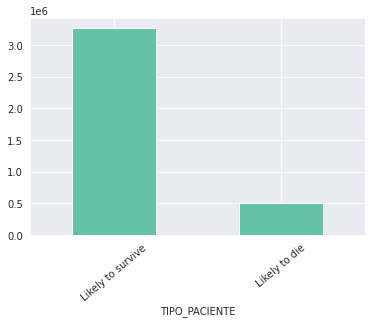

In [ ]:
ax = df[["TIPO_PACIENTE"]].value_counts().plot(kind="bar")
ax.set_xticklabels(['Likely to survive', 'Likely to die'], rotation=40)
plt.show()

In [ ]:
# categorical values have numerical identifier 
name_dict = {'SI': 1, 'NO': 2, 'DO NOT KNOW': 97, 'ANSWER REFUSED': 98, 'NOT APPLICABLE': 99}
#name_dict = {1: 'SI', 2: 'NO', 97: 'DO NOT KNOW', 98: 'ANSWER REFUSED', 99: 'NOT APPLICABLE'}

This dataset has 39 features, making it challenging to analyze it immediately. To make it easier, the features have been separated into three categories:

- 1. Medical History:

In [ ]:
medical_history = ['DIABETES',  #Diabetes = categorical (SI/NO/DONT KNOW/ANSWER REFUSED/NA)
    'OBESIDAD', #Obesity = categorical (SI/NO/DONT KNOW/ANSWER REFUSED/NA)
    'ASMA', #Asthma = categorical (SI/NO/DONT KNOW/ANSWER REFUSED/NA)
    'HIPERTENSION', #Hypertension = categorical (SI/NO/DONT KNOW/ANSWER REFUSED/NA)
    'RENAL_CRONICA', #Chronic renal failure = categorical (SI/NO/DONT KNOW/ANSWER REFUSED/NA)
    'CARDIOVASCULAR', #Cardiovascular diseases = categorical (SI/NO/DONT KNOW/ANSWER REFUSED/NA)
    'EMBARAZO', #Pregnancy = categorical (SI/NO/DONT KNOW/ANSWER REFUSED/NA)
    'TABAQUISMO', #Smoking = categorical (SI/NO/DONT KNOW/ANSWER REFUSED/NA)
    'EPOC', #COPD = categorical (SI/NO/DONT KNOW/ANSWER REFUSED/NA)
    'INMUSUPR', #Immunosuppressive drugs = categorical (SI/NO/DONT KNOW/ANSWER REFUSED/NA)
    'OTRA_COM' #Other chronic illnesses = categorical (SI/NO/DONT KNOW/ANSWER REFUSED/NA)
]

Passing the minor parameter of set_xticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.
Passing the minor parameter of set_xticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.
Passing the minor parameter of set_xticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.
Passing the minor parameter of set_xticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.
Passing the minor parameter of set_xticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.
Passing the minor parameter of set_xticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.
Passing the minor parameter of set_xticks() position

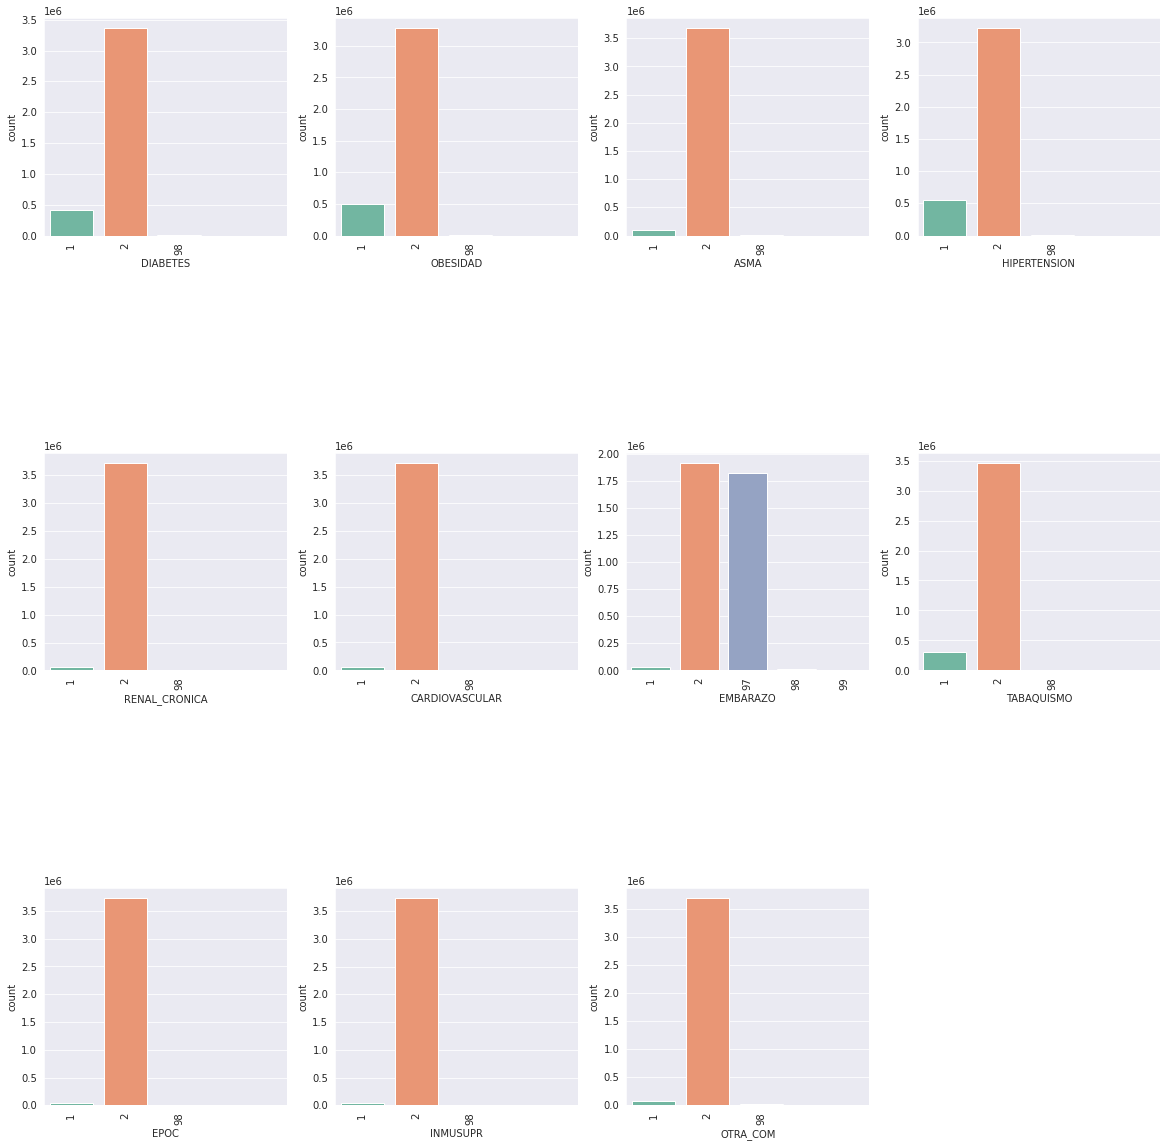

In [ ]:
fig, ax = plt.subplots(3, 4, figsize=(20, 20))
fig.subplots_adjust(hspace=1)
for variable, subplot in zip(medical_history, ax.flatten()):
    chart = sns.countplot(x=df[variable], ax=subplot)
    chart.set_xticks(range(len(name_dict)), list(name_dict.keys()))
    chart.set_xticklabels(chart.get_xticklabels(), rotation=90)
fig.delaxes(ax[2,3])

- We can detect an high number of NaNs in 'EMBARAZO' (this feature won't be of much help in our research due to this high number of nans).<br>
- We can observe that the majority of the patients wasn't in poor health (2=NO). <br>

<hr>

- 2. Demographic Data

In [ ]:
demographic_data = ['SEXO', #gender (M/F)=(1/2)
                    'NACIONALIDAD', #nationality (1=mexican , 2=foreigner)
                    'INDIGENA', #indigeneous = categorical (SI/NO/DONT KNOW/ANSWER REFUSED/NA)
                    'HABLA_LENGUA_INDIG', #Indigeneous language = categorical (SI/NO/DONT KNOW/ANSWER REFUSED/NA)
                    'MIGRANTE', #migrant = categorical (SI/NO/DONT KNOW/ANSWER REFUSED/NA)
                    'PAIS_ORIGEN', #state of birth = categorical (text)
                    'PAIS_NACIONALIDAD', #state of residence  = categorical (text)
                    'ENTIDAD_NAC', #entity where patient was born = categorical (text)
                    'ENTIDAD_RES', #entity where patient is resident = categorical (text)
                    'EDAD', #age = numerical
                    'MUNICIPIO_RES', #municial where patient is resident = categorical (text)
                   ]

[Text(0, 0, 'MEXICAN'), Text(0, 0, 'FOREIGNER')]

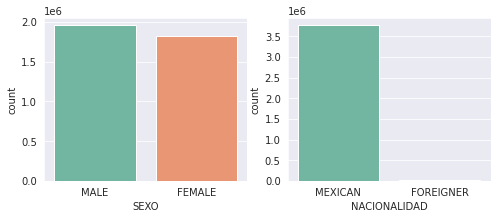

In [ ]:
fig, (ax1,ax2) = plt.subplots(1, 2, figsize=(8, 3))
sns.countplot(x=df[demographic_data[0]], ax=ax1).set_xticklabels(['MALE', 'FEMALE'])
sns.countplot(x=df[demographic_data[1]], ax=ax2).set_xticklabels(['MEXICAN', 'FOREIGNER'])

Passing the minor parameter of set_xticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.
Passing the minor parameter of set_xticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.
Passing the minor parameter of set_xticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.


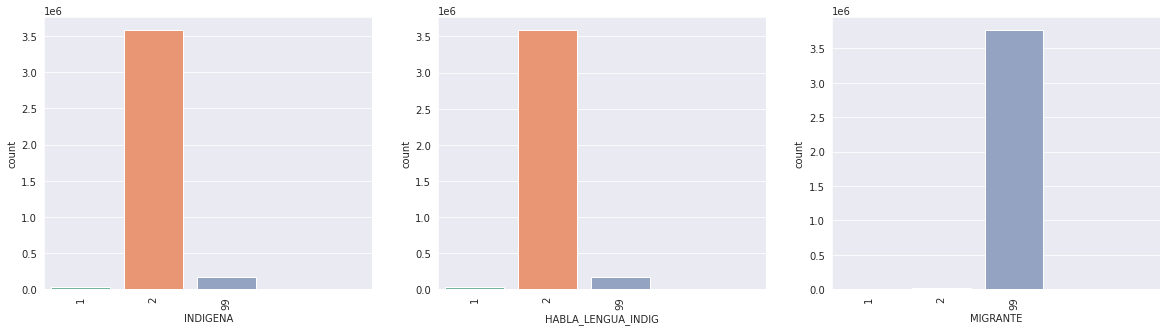

In [ ]:
fig, ax = plt.subplots(1, 3, figsize=(20, 5))
for variable, subplot in zip(demographic_data[2:5], ax.flatten()):
    chart = sns.countplot(x=df[variable], ax=subplot)
    chart.set_xticks(range(len(name_dict)), list(name_dict.keys()))
    chart.set_xticklabels(chart.get_xticklabels(), rotation=90)

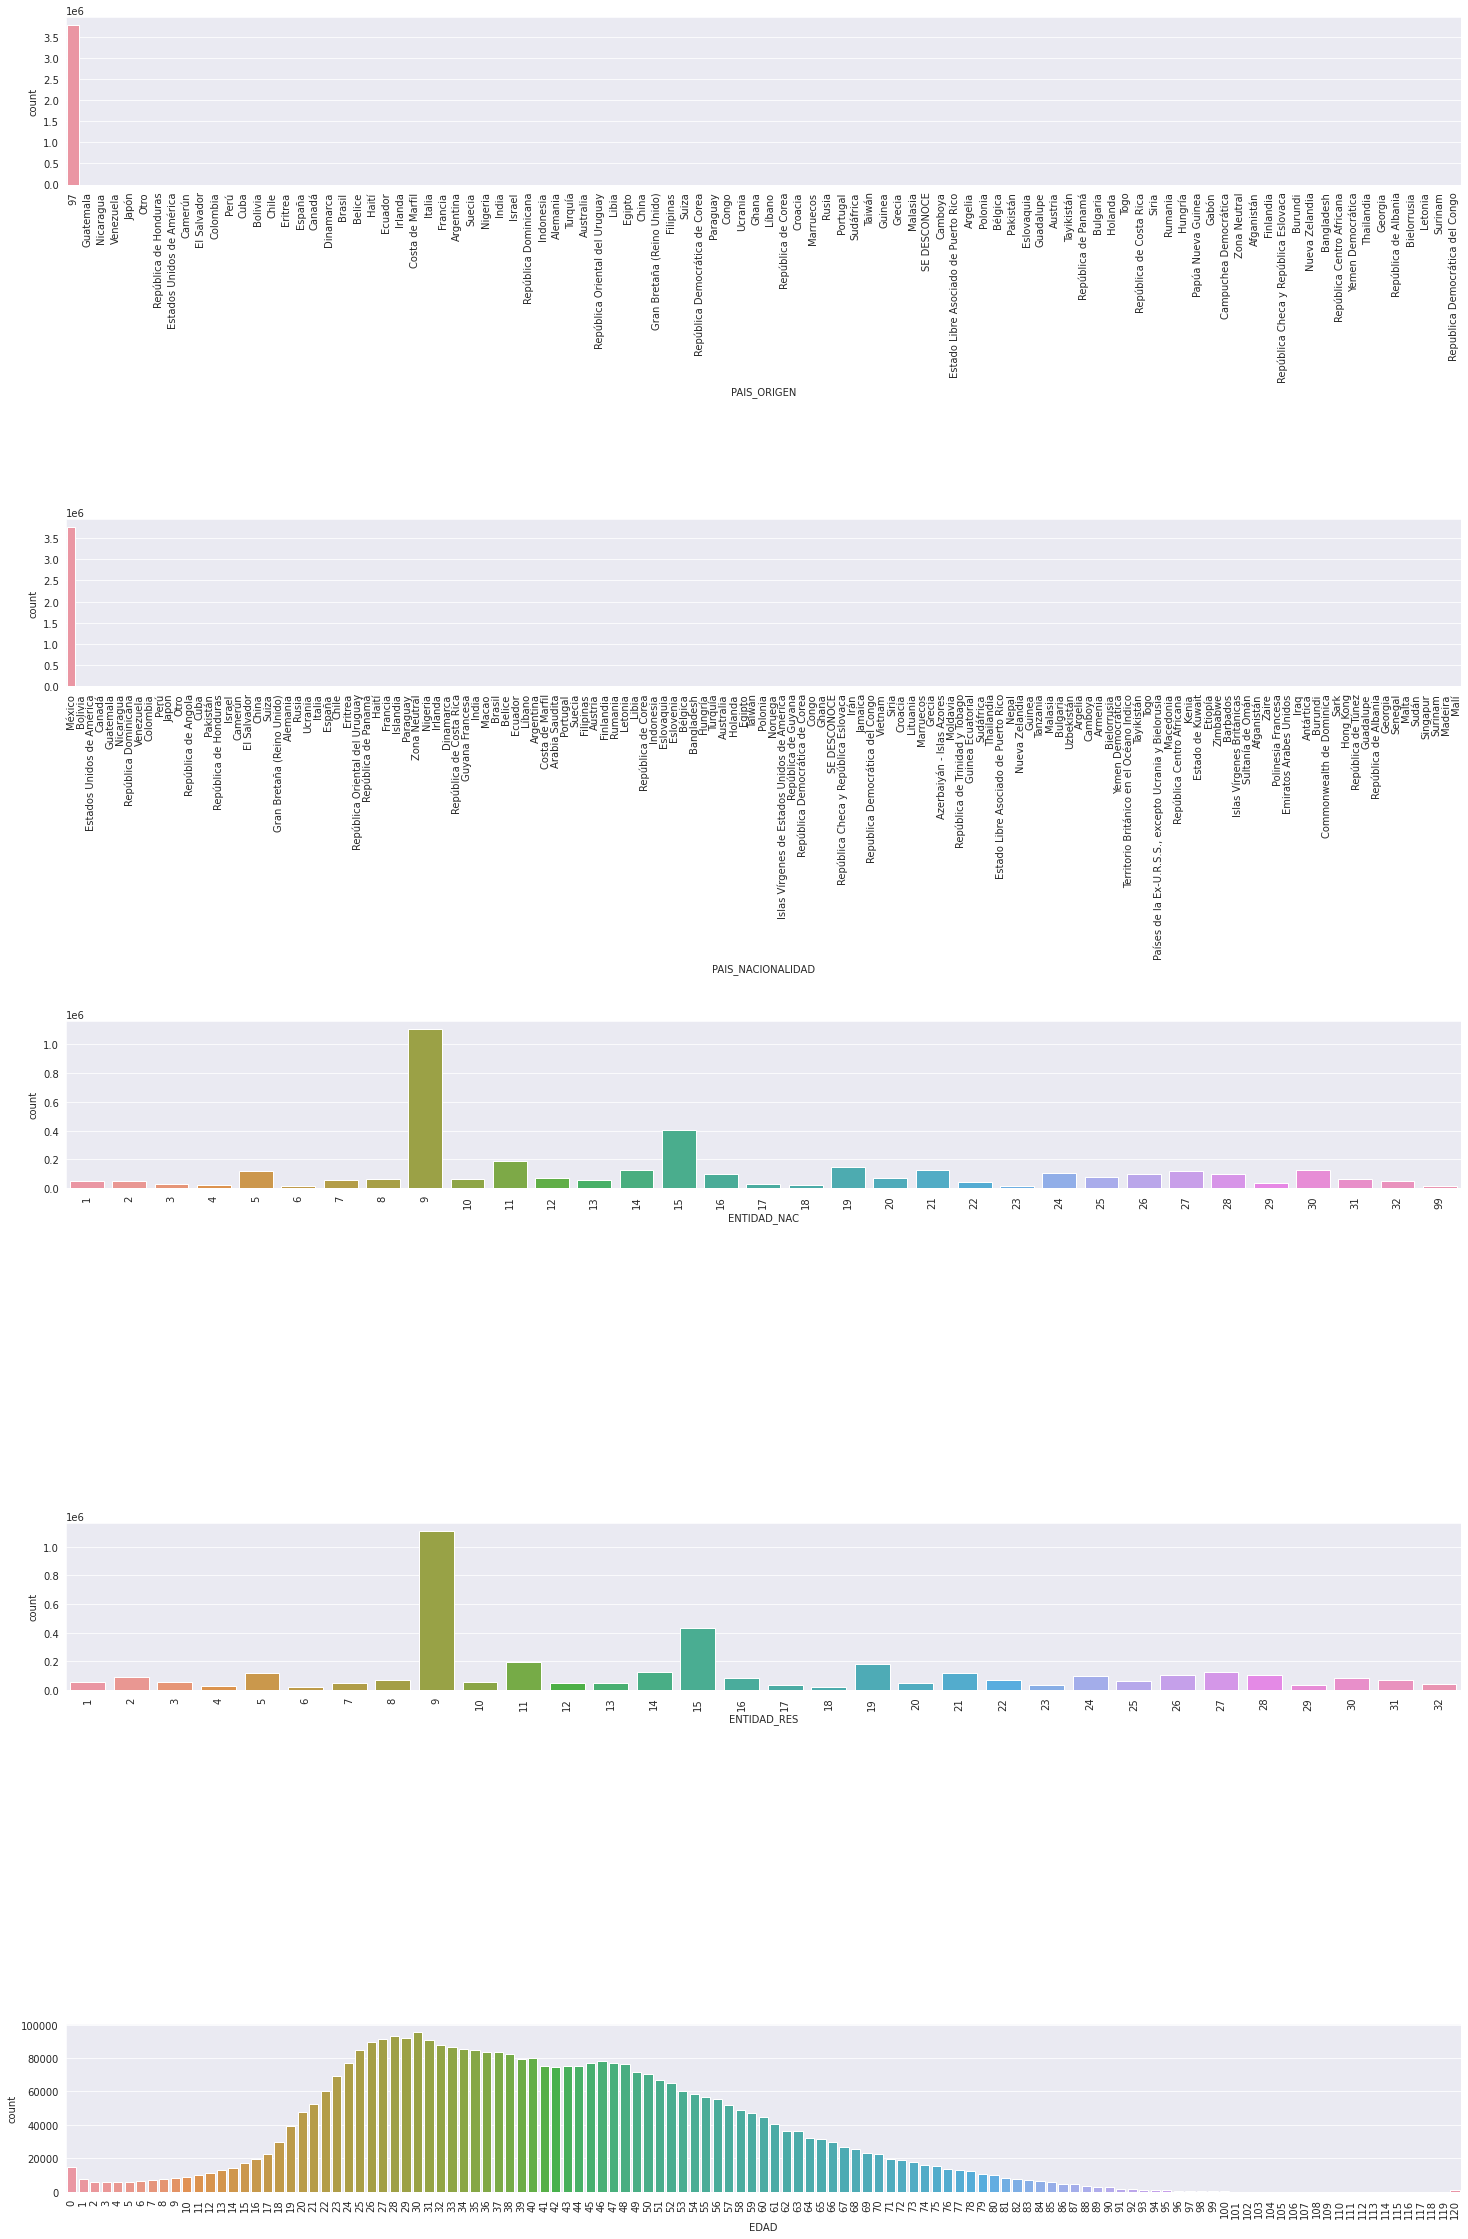

In [ ]:
fig, ax = plt.subplots(5, 1, figsize=(25, 40))
fig.subplots_adjust(hspace=2)
for variable, subplot in zip(demographic_data[5:10], ax.flatten()):
    chart = sns.countplot(x=df[variable], ax=subplot)
    chart.set_xticklabels(chart.get_xticklabels(), rotation=90)

In [ ]:
df[['MUNICIPIO_RES']].value_counts().sort_index()

MUNICIPIO_RES
1                100438
2                140073
3                120881
4                140736
5                200309
                  ...  
567                   3
568                   6
569                   1
570                 283
999                  37
Length: 520, dtype: int64

- in 'MIGRANTE' (migran) we can see many NaN's (97,98,99)
- from the other features we can derive that most of the people is mexican
- we can notice some outliers in the feature 'EDAD' (age): it's not likely that someone had 120 years
- male and female are balanced

<hr>

- 3. Recent Medical Info

In [ ]:
medical_info = ['ID_REGISTRO', #id register = categorical (text)
                
                'ORIGEN', #system of respiratory disease monitoring health units (USMER) = categorical (SI/NO/DONT KNOW/ANSWER REFUSED/NA)
                'INTUBADO', #if the patient required intubation = categorical (SI/NO/DONT KNOW/ANSWER REFUSED/NA)
                'NEUMONIA', #PNEUMONIA = categorical (SI/NO/DONT KNOW/ANSWER REFUSED/NA)
                'OTRO_CASO', #if it has had contact with other covid cases = categorical (SI/NO/DONT KNOW/ANSWER REFUSED/NA)
                'TOMA_MUESTRA_LAB', #sample lab taken = categorical (SI/NO/DONT KNOW/ANSWER REFUSED/NA)
                'RESULTADO_LAB', #test covid19 result = categorical (COVID/HEALTHY/DONT KNOW/ANSWER REFUSED/NA)
                'TOMA_MUESTRA_ANTIGENO', #test antigeno taken = categorical (SI/NO/DONT KNOW/ANSWER REFUSED/NA)
                'RESULTADO_ANTIGENO', #test covid19 antigeno result = categorical (COVID/HEALTHY/DONT KNOW/ANSWER REFUSED/NA)
                'UCI',#if the patients was in the intense unit = categorical (SI/NO/DONT KNOW/ANSWER REFUSED/NA)
                
                'CLASIFICACION_FINAL', #Identifies if the patient is a case of COVID-19 = categorical (1-7)
                'ENTIDAD_UM', #entity of the medical unit = categorical
                'TIPO_PACIENTE', #type of attention that the patient has received on arrival = categorical (Ambulatorio/hospitalizado)
                
                'FECHA_SINTOMAS', #date of start symbols (YYYY-MM-DD)
                'FECHA_INGRESO', #date of arrival into medical unit (YYYY-MM-DD)
                'FECHA_DEF', #date of death (YYYY-MM-DD)
]

Passing the minor parameter of set_xticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.
Passing the minor parameter of set_xticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.
Passing the minor parameter of set_xticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.
Passing the minor parameter of set_xticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.
Passing the minor parameter of set_xticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.
Passing the minor parameter of set_xticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.
Passing the minor parameter of set_xticks() position

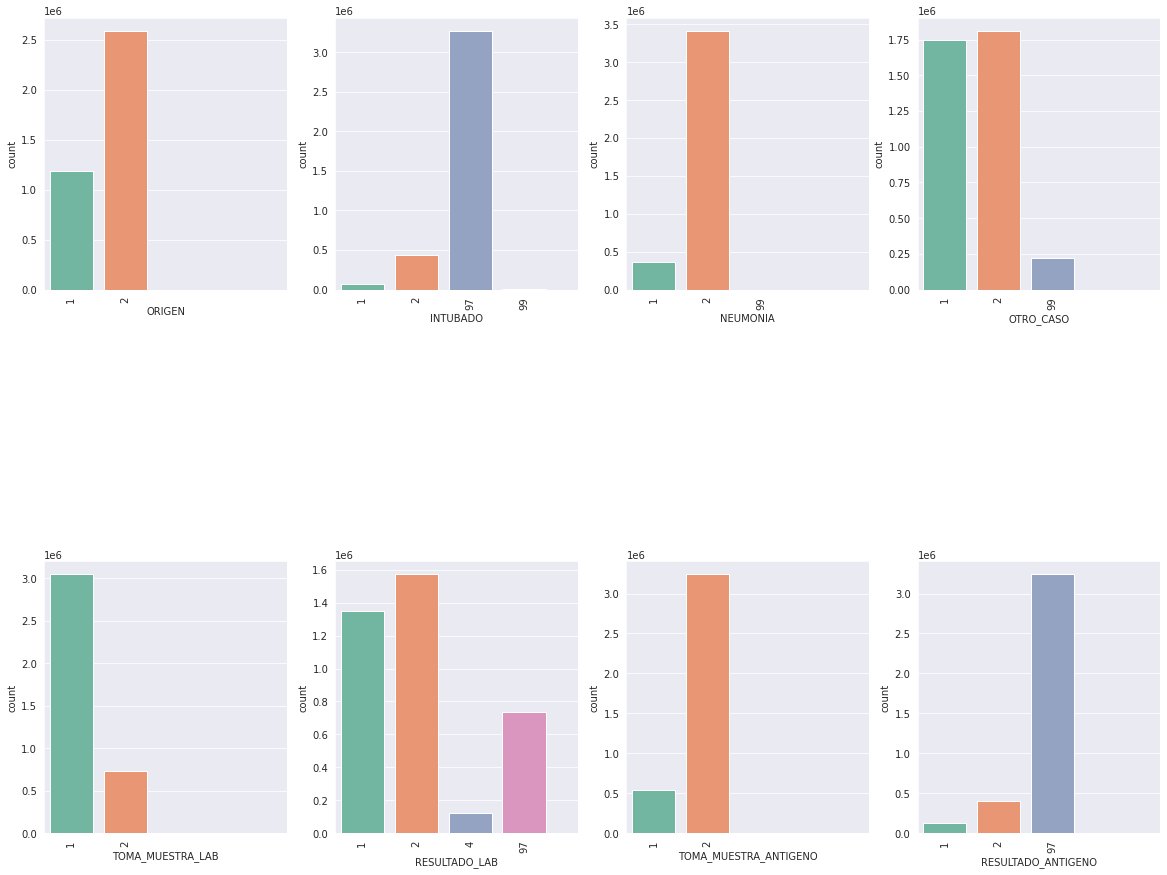

In [ ]:
fig, ax = plt.subplots(2, 4, figsize=(20, 15))
fig.subplots_adjust(hspace=1)
for variable, subplot in zip(medical_info[1:9], ax.flatten()):
    chart = sns.countplot(x=df[variable], ax=subplot)
    chart.set_xticks(range(len(name_dict)), list(name_dict.keys()))
    chart.set_xticklabels(chart.get_xticklabels(), rotation=90)

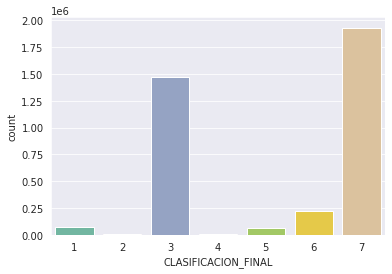

In [ ]:
sns.countplot(x=df['CLASIFICACION_FINAL'])

In [ ]:
# death is set to 9999-99-99 if patient is not dead
df[medical_info[-1]].value_counts()

#convert into nan to plot it
df.replace('9999-99-99', np.nan, inplace=True)

In [ ]:
# convert to date
for f in medical_info[13:16]:
    df[f] =  pd.to_datetime(df[f])

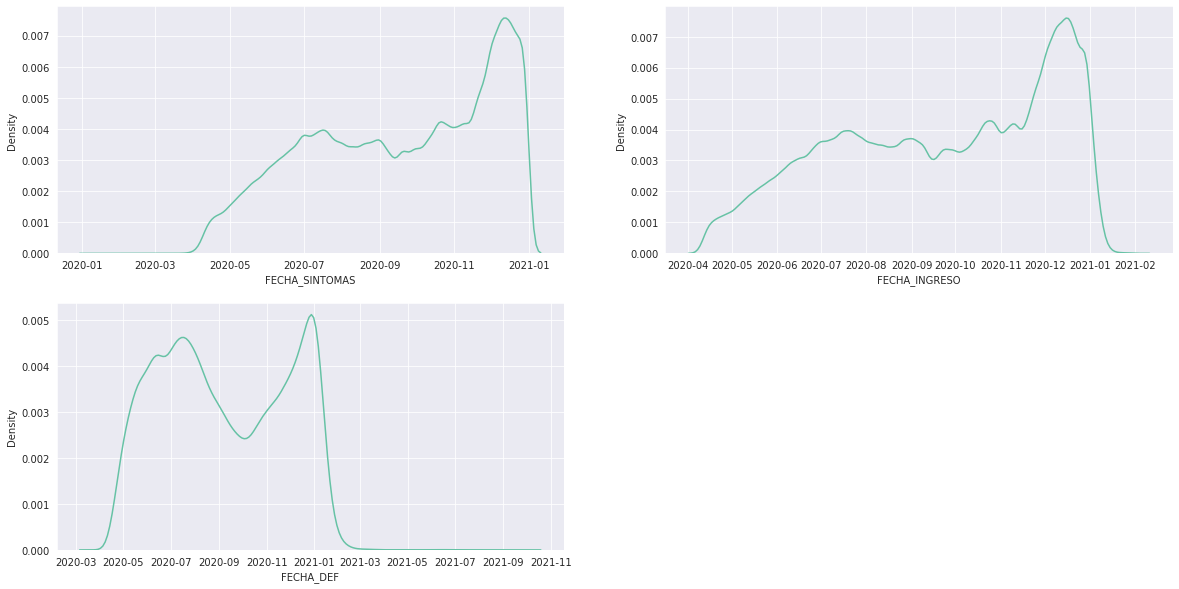

In [ ]:
# fig, ax = plt.subplots(2,2, figsize=(20, 10))
# for variable, subplot in zip(medical_info[13:16], ax.flatten()):
#     chart = sns.kdeplot(x=df[variable], ax=subplot)
# fig.delaxes(ax[1,1])

- From the 'FECHA_SINTOMAS' we can clearly see a peak around the lasts month of the 2020, meaning covid19 here are a massive spread. On the same dates, we can see that many people went to the hospital ('FECHA_INGRESO'). The 'Start of symptoms' and 'Arrival to the hospital' curve are similar: there is a correlation between the two. 

- The peak for the deaths, on the other hand, are arount the lasts month of 2020 as well but also on the summer of 2020.

### **2.3 - Data Exploration:**

In [ ]:
# we are going to consider 97,98,99 as NaN's values since they correspond to Don't know, Answer Refused, Not Applicable
# and this values are of no use to us
df.replace([97, 98, 99, "97", "98", "99"], np.nan, inplace=True)

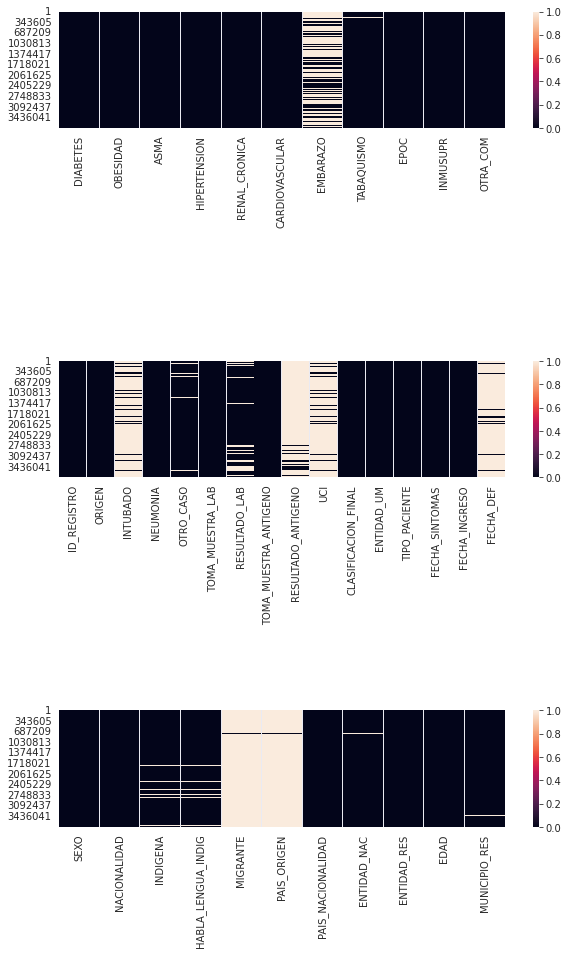

In [ ]:
# sections = [medical_history, medical_info, demographic_data]

# fig, ax = plt.subplots(3,1, figsize=(10, 15))
# fig.subplots_adjust(hspace=2)

# for features, subplot in zip(sections, ax.flatten()):
#     sns.heatmap(df[features].isna(), ax = subplot)

From this heatmap we can individualize with more clarity the columns with high percentage of nan values: like 'MIGRANTE' for example and 'UCI', 'RESULTADO ANTIGENO', 'INTUBADO',  'EMBARAZO'. Columns that have an high percentage of nan values are no useful to our problem. They will be removed in the future. 

Due to the nature of our problem (decide is a patient is likely to die or to survive) we won't know the value of the column 'date of death' in real life cases. So we can remove it. 

1. How many days between the start of sintoms and the ingress at the hospital?

In [ ]:
df['DAYS_IN_BETWEEN'] = (df['FECHA_INGRESO'] - df['FECHA_SINTOMAS']).astype('timedelta64[D]').astype('int64')

In [ ]:
df['DAYS_IN_BETWEEN'].value_counts().sort_index()

-13          1
 0      709605
 1      431457
 2      499507
 3      514451
         ...  
 153         1
 166         1
 247         1
 258         1
 265         1
Name: DAYS_IN_BETWEEN, Length: 91, dtype: int64

Text(0.5, 1.0, 'Days between start of syntoms and hospitalization')

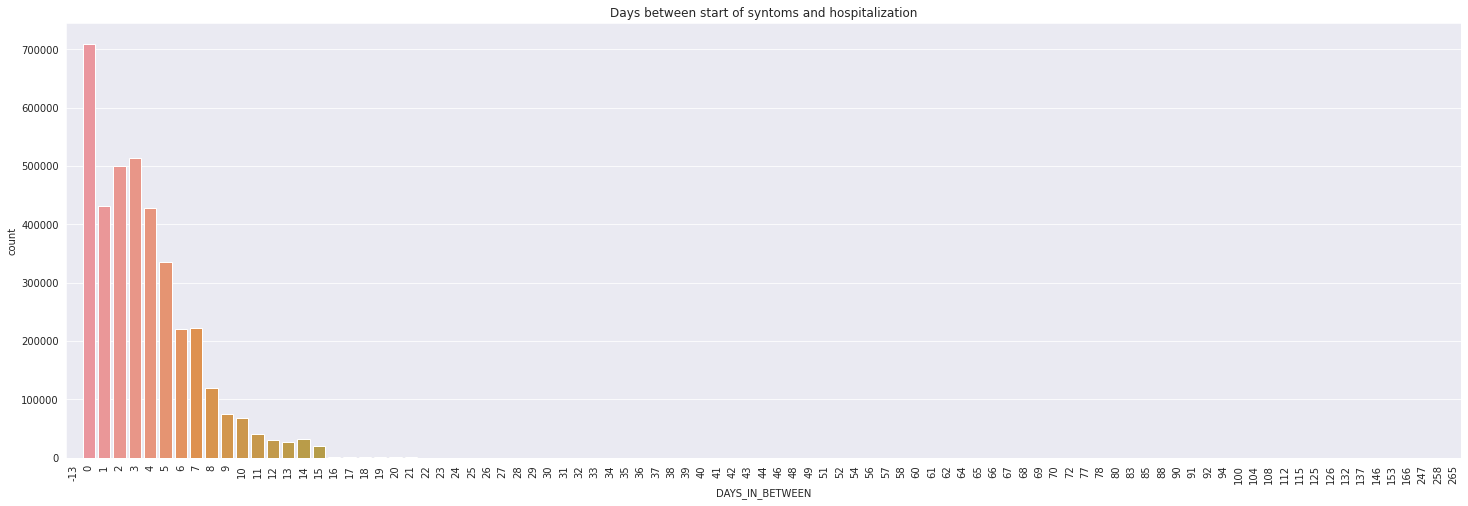

In [ ]:
# plt.figure(figsize=(25, 8))
# cplot = sns.countplot(x=df["DAYS_IN_BETWEEN"])
# cplot.set_xticklabels(cplot.get_xticklabels(), rotation=90)
# cplot.set_title('Days between start of syntoms and hospitalization')

2. Is there a correlation between the days and the death?

In [ ]:
# df_dead = df[['DAYS_IN_BETWEEN', 'FECHA_DEF']].copy()
# df_dead['DEAD'] = np.where(df_dead[['FECHA_DEF']].isna(), False, True)
# df_dead[['DAYS_IN_BETWEEN', 'DEAD']].corr()

,DAYS_IN_BETWEEN,DEAD
DAYS_IN_BETWEEN,1.000000,0.096023
DEAD,0.096023,1.000000


We can say that no, there is not a visible correlation. Since the correlation between the two features is close to 0. 

3. Explore the age of people and their classification

[Text(0, 0, 'Likely to survive'), Text(0, 0, 'Likely to die')]

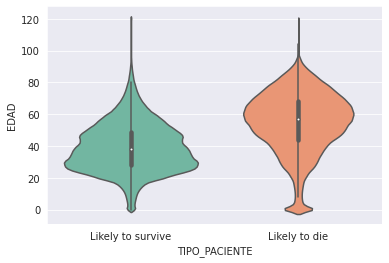

In [ ]:
# violin_plot = sns.violinplot(x=df["TIPO_PACIENTE"], y = df['EDAD'])
# violin_plot.set_xticklabels(['Likely to survive', 'Likely to die'])

From the violion plot above, we can conclude that most of the people that were hospitalized (likely to die) had 60 years. The distrubution of people that were considered likely to die grows with the age until 60. 

Most of the people that were likely to survive has around 20-40 years instead.

4. Is the distribution of people that were likely to die/survive different between man and women?

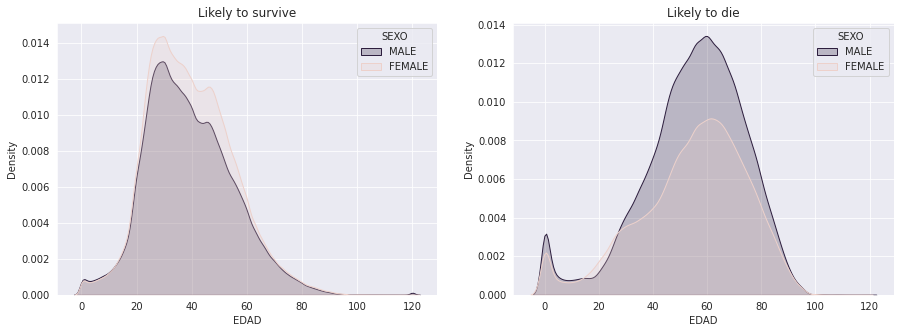

In [ ]:
# fig, (ax1, ax2) = plt.subplots(1,2, figsize=(15, 5))

# c1 = sns.kdeplot(data=df[df['TIPO_PACIENTE']==1], x='EDAD', hue = 'SEXO', fill=True, ax=ax1)
# c1.set_title("Likely to survive")
# c2 = sns.kdeplot(data=df[df['TIPO_PACIENTE']==2], x='EDAD', hue = 'SEXO', fill=True, ax=ax2)
# c2.set_title("Likely to die")

# c1.legend(title='SEXO', labels=['MALE', 'FEMALE'])
# c2.legend(title='SEXO', labels=['MALE', 'FEMALE'])

# plt.show()

From the density plot we can see that the percentage of mens in their 60 that were likely to die is higher than womens. However the difference in sex between the ones that were likely to survive is minimal.

In [ ]:
# # correlation plot
# df_corr = df.copy()
# df_corr.pop('TIPO_PACIENTE')

# plt.figure(figsize=(25, 25))
# corr_matrix=df_corr.corr()

# mask = np.zeros_like(corr_matrix)
# mask[np.triu_indices_from(mask)] = True

# sns.heatmap(corr_matrix, mask=mask, square=True, linewidth=.5, annot=True)

The correlation plot show us wich features are highly correlated between themselves and which not. This can be useful because if we notice that two features are highly correlated (the more the correlation close to 1/-1, the more correlated) we can delete one and leave the other without removing information but improving training time.

For example 'ENTIAD_RES' and 'ENTIAD_UM' have an high correlation (0.97) so we can remove 'ENTIAD_RES' and keep 'ENTIAD_UM'.

In [ ]:
df.drop('DAYS_IN_BETWEEN', axis=1, inplace=True)

# 3. Data Preparation

In [ ]:
import gc; gc.collect()

78108

### **3.0 - Remove un-necessary columns**

In [ ]:
# remove the id in the register
df.drop(['ID_REGISTRO'], axis=1, inplace=True)
# remove date of insert into register
df.drop(['FECHA_ACTUALIZACION'], axis=1, inplace=True)
# date of death - if we want to predict if a patient is likely to die or survive, we won't have this feature when making real time prediction
df.drop(['FECHA_DEF'], axis=1, inplace=True)

### **3.1 - Remove NaNs**

In [ ]:
df.isna().mean()*100

ORIGEN                    0.000000
SECTOR                    0.000265
ENTIDAD_UM                0.000000
SEXO                      0.000000
ENTIDAD_NAC               0.464145
ENTIDAD_RES               0.000000
MUNICIPIO_RES             0.634637
TIPO_PACIENTE             0.000000
FECHA_INGRESO             0.000000
FECHA_SINTOMAS            0.000000
INTUBADO                 86.752839
NEUMONIA                  0.000212
EDAD                      0.026008
NACIONALIDAD              0.000000
EMBARAZO                 48.621668
HABLA_LENGUA_INDIG        4.474341
INDIGENA                  4.380841
DIABETES                  0.318893
EPOC                      0.296483
ASMA                      0.291589
INMUSUPR                  0.300108
HIPERTENSION              0.298785
OTRA_COM                  0.450942
CARDIOVASCULAR            0.295160
OBESIDAD                  0.284683
RENAL_CRONICA             0.291403
TABAQUISMO                0.307119
OTRO_CASO                 5.780815
TOMA_MUESTRA_LAB    

#### **3.1.1 - Logical conclusions**

Before deciding the operations to make on the nan columns, based on the data gathered, we will manually substitute some nans based on some researches on the dataset.

In [ ]:
# if the patient was sent home, the column 'INTUBADO' won't have any value because the patient wasn't intubated but sent home
df[df['INTUBADO'].isna()].head(5)
df.loc[(df['INTUBADO'].isna() & df['TIPO_PACIENTE']==1), 'INTUBADO'] = 2

In [ ]:
# If you didn't change the sex legally on papers, if you're assigned as a man on the entrace of the Hospital, you can't be pregnant
df[df['EMBARAZO'].isna() & df['SEXO']==1] # sexo = gender (M/F)=(1/2)
df.loc[(df['EMBARAZO'].isna() & df['SEXO']==1), 'EMBARAZO'] = 2

In [ ]:
# If you are a migrant, your nationality won't be Mexican
df[df['MIGRANTE'].isna()]
df.loc[(df['MIGRANTE'].isna() & df['NACIONALIDAD']==1), 'MIGRANTE'] = 2 # if your nationality is mexican, you're not a migrant
df.loc[(df['MIGRANTE'].isna() & df['NACIONALIDAD']==2), 'MIGRANTE'] = 1 # if your nationality is not mexican, you're a migrant

#### **3.2 - Traditional Methods**

In [ ]:
# Delete columns containing either 65% or more than 65% NaN Values
perc = 65.0
min_count =  int(((100-perc)/100)*df.shape[0] + 1)
df.dropna(axis=1, thresh=min_count, inplace=True)

In [ ]:
# Delete rows containing more than 10/39 NaN values
df.dropna(thresh=df.shape[1] - 10, axis=0, inplace=True)

In [ ]:
# for columns with percentage of nan<10%, we are going to impute values using the simple imputer (median or most frequent)
nan_columns = df.loc[:, df.isna().any()].loc[:, df.isna().mean()<0.10].columns.tolist()

for col in nan_columns:
    if is_numeric_dtype(df[col]):
        mean_imputer = SimpleImputer(strategy='median')
        df[col] = mean_imputer.fit_transform(df[col].values.reshape(-1,1))
    else:
        mean_imputer = SimpleImputer(strategy='most_frequent')
        df[col] = mean_imputer.fit_transform(df[col].values.reshape(-1,1))

In [ ]:
# get columns that still have nan values
nans_columns = df.loc[:, df.isna().any()].columns.tolist()
nans_columns

['RESULTADO_LAB']

In [ ]:
# for more than 10% missing values we are going to use MICE
mice_imputer = IterativeImputer(estimator=linear_model.BayesianRidge(), n_nearest_features=None, imputation_order='ascending')

df_new = pd.DataFrame()

for col in nans_columns:
    df_new[col] = pd.DataFrame(mice_imputer.fit_transform(df[col].values.reshape(-1, 1)), columns=[col])

In [ ]:
df.drop(nans_columns, inplace=True, axis=1)

In [ ]:
df = pd.concat([df.reset_index(), df_new.reset_index()], axis=1)
df.drop('index', axis=1, inplace=True)

### **3.2 - Convert Categorical Data to Numerical**

In [ ]:
obj_columns = df.select_dtypes(exclude=np.number).columns.tolist()
obj_columns

['FECHA_INGRESO', 'FECHA_SINTOMAS', 'PAIS_NACIONALIDAD']

In [ ]:
df_cols = pd.DataFrame()

for col in obj_columns:
    labels = LabelEncoder().fit(df[col]).transform(df[col])
    df_cols = pd.concat([df_cols, pd.DataFrame(labels, columns=[col])], axis=1)
    
df_cols.head()

,FECHA_INGRESO,FECHA_SINTOMAS,PAIS_NACIONALIDAD
0,238,272,84
1,10,46,84
2,107,139,84
3,128,167,84
4,260,300,84


In [ ]:
df.drop(obj_columns, axis=1, inplace=True)

In [ ]:
df = pd.concat([df, df_cols], axis=1)

### **3.4 - Remove outliers**

In [ ]:
df.describe()

,ORIGEN,SECTOR,ENTIDAD_UM,SEXO,ENTIDAD_NAC,ENTIDAD_RES,MUNICIPIO_RES,TIPO_PACIENTE,INTUBADO,NEUMONIA,...,TABAQUISMO,OTRO_CASO,TOMA_MUESTRA_LAB,TOMA_MUESTRA_ANTIGENO,CLASIFICACION_FINAL,MIGRANTE,RESULTADO_LAB,FECHA_INGRESO,FECHA_SINTOMAS,PAIS_NACIONALIDAD
count,3.773875e+06,3.773875e+06,3.773875e+06,3.773875e+06,3.773875e+06,3.773875e+06,3.773875e+06,3.773875e+06,3.773875e+06,3.773875e+06,...,3.773875e+06,3.773875e+06,3.773875e+06,3.773875e+06,3.773875e+06,3.773875e+06,3.773875e+06,3.773875e+06,3.773875e+06,3.773875e+06
mean,1.685681e+00,9.512099e+00,1.428820e+01,1.482528e+00,1.494822e+01,1.460101e+01,3.229334e+01,1.134002e+00,1.982934e+00,1.903675e+00,...,1.917157e+00,1.536540e+00,1.194163e+00,1.857278e+00,5.214772e+00,1.998960e+00,1.639108e+00,1.622638e+02,1.986585e+02,8.386624e+01
std,4.642443e-01,3.568299e+00,7.889429e+00,4.996947e-01,7.833698e+00,7.821695e+00,4.404461e+01,3.406543e-01,1.295184e-01,2.950359e-01,...,2.756444e-01,4.986631e-01,3.955548e-01,3.497889e-01,1.985804e+00,3.223296e-02,6.190197e-01,7.413044e+01,7.432564e+01,3.371302e+00
min,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,...,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,1.000000e+00,4.000000e+00,9.000000e+00,1.000000e+00,9.000000e+00,9.000000e+00,7.000000e+00,1.000000e+00,2.000000e+00,2.000000e+00,...,2.000000e+00,1.000000e+00,1.000000e+00,2.000000e+00,3.000000e+00,2.000000e+00,1.000000e+00,1.000000e+02,1.360000e+02,8.400000e+01
50%,2.000000e+00,1.200000e+01,1.100000e+01,1.000000e+00,1.300000e+01,1.300000e+01,1.700000e+01,1.000000e+00,2.000000e+00,2.000000e+00,...,2.000000e+00,2.000000e+00,1.000000e+00,2.000000e+00,7.000000e+00,2.000000e+00,1.639108e+00,1.710000e+02,2.080000e+02,8.400000e+01
75%,2.000000e+00,1.200000e+01,2.000000e+01,2.000000e+00,2.100000e+01,2.000000e+01,3.900000e+01,1.000000e+00,2.000000e+00,2.000000e+00,...,2.000000e+00,2.000000e+00,1.000000e+00,2.000000e+00,7.000000e+00,2.000000e+00,2.000000e+00,2.320000e+02,2.690000e+02,8.400000e+01
max,2.000000e+00,1.300000e+01,3.200000e+01,2.000000e+00,3.200000e+01,3.200000e+01,9.990000e+02,2.000000e+00,2.000000e+00,2.000000e+00,...,2.000000e+00,2.000000e+00,2.000000e+00,2.000000e+00,7.000000e+00,2.000000e+00,4.000000e+00,2.940000e+02,3.030000e+02,1.400000e+02


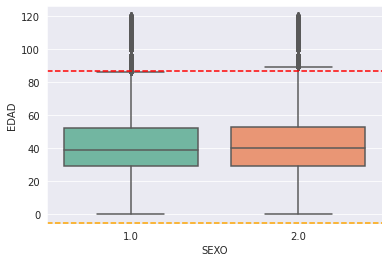

In [ ]:
# outliers in edad
q3 = df['EDAD'].quantile(.75)
q1 = df['EDAD'].quantile(.25)
iqr = q3-q1
topcut = q3+1.5*iqr
lowcut = q1-1.5*iqr

ax = sns.boxplot(x='SEXO', y='EDAD', data=df)
ax.axhline(topcut,c='red',ls='--')
ax.axhline(lowcut,c='orange',ls='--')

In [ ]:
columns = df.columns
columns = columns.drop('TIPO_PACIENTE')
columns

Index(['ORIGEN', 'SECTOR', 'ENTIDAD_UM', 'SEXO', 'ENTIDAD_NAC', 'ENTIDAD_RES',
       'MUNICIPIO_RES', 'INTUBADO', 'NEUMONIA', 'EDAD', 'NACIONALIDAD',
       'EMBARAZO', 'HABLA_LENGUA_INDIG', 'INDIGENA', 'DIABETES', 'EPOC',
       'ASMA', 'INMUSUPR', 'HIPERTENSION', 'OTRA_COM', 'CARDIOVASCULAR',
       'OBESIDAD', 'RENAL_CRONICA', 'TABAQUISMO', 'OTRO_CASO',
       'TOMA_MUESTRA_LAB', 'TOMA_MUESTRA_ANTIGENO', 'CLASIFICACION_FINAL',
       'MIGRANTE', 'RESULTADO_LAB', 'FECHA_INGRESO', 'FECHA_SINTOMAS',
       'PAIS_NACIONALIDAD'],
      dtype='object')

In [ ]:
# using IQR range
for col in columns:
    q3 = df[col].quantile(.75)
    q1 = df[col].quantile(.25)
    iqr = q3-q1
    topcut = q3+1.5*iqr
    lowcut = q1-1.5*iqr

    df.drop(df.index[df[col]>topcut], inplace=True)
    df.drop(df.index[df[col]<lowcut], inplace=True)

### **3.3 Normalization:** <br>

In [ ]:
# we need normalization for the KNN imputer
scaler = MinMaxScaler()
df = pd.DataFrame(scaler.fit_transform(df), columns = df.columns)

### **3.5 - Remove redundant columns**

In [ ]:
X = df.copy()
y = X.pop('TIPO_PACIENTE')

In [ ]:
# remove columns that are higly correlated between themselves
cor_matrix = X.corr().abs()
upper_tri = cor_matrix.where(np.triu(np.ones(cor_matrix.shape),k=1).astype(bool))
to_drop = [column for column in upper_tri.columns if any(upper_tri[column] > 0.75)]
to_drop

['ENTIDAD_NAC', 'ENTIDAD_RES', 'RESULTADO_LAB', 'FECHA_SINTOMAS']

In [ ]:
X.drop(to_drop, axis=1, inplace=True)

In [ ]:
# save result 
df = pd.concat([X, y], axis=1)

In [ ]:
df.to_csv(path + "/COVID2022_processed.csv")

### **3.6- Feature Selection**

The curse of dimensionality is a problem that occurs when the dimensionality rises and the volume of space expands so quickly that available data becomes sparse. The amount of data required to produce a reliable conclusion sometimes climbs exponentially with dimensionality. Therefore it's useful to reduce the dimensionality of the data (reduce the features) to avoid this problem. Also, dimensionality reduction is useful for reducing overfitting, improving accuracy and reducing training times.

#### **3.6.1 - Principal Component Analysis**

In [ ]:
# build the covariance matrix that represents the correlation between two variables
df_cov_matrix = np.cov(X.T)

In [ ]:
# calculate eigenvalues and eigenvectors
eig_vals, eig_vecs = np.linalg.eig(df_cov_matrix)
eig_pairs = [(np.abs(eig_vals[i]), eig_vecs[:,i]) for i in range(len(eig_vals))]

total = sum(eig_vals)
var_exp = [(i / total)*100 for i in sorted(eig_vals, reverse=True)]
print(f"Variance captured by each component is: {var_exp}")

cum_var_exp = np.cumsum(var_exp)
print("Cumulative variance captured as we travel with each component",cum_var_exp)

Variance captured by each component is: [22.519589740597144, 19.918907430375256, 19.05731838180894, 16.568043387120422, 6.303707170598266, 5.886045762703391, 4.252041823074523, 3.0436899018939463, 2.4506564018281005, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
Cumulative variance captured as we travel with each component [ 22.51958974  42.43849717  61.49581555  78.06385894  84.36756611
  90.25361187  94.5056537   97.5493436  100.         100.
 100.         100.         100.         100.         100.
 100.         100.         100.         100.         100.
 100.         100.         100.         100.         100.
 100.         100.         100.         100.        ]


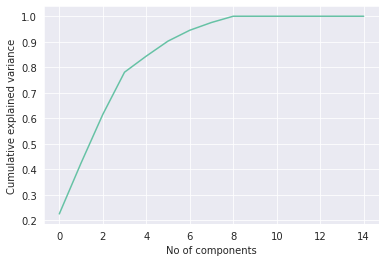

In [ ]:
pca = PCA().fit(X)
plt.plot(np.cumsum(pca.explained_variance_ratio_)[:15])
plt.xlabel("No of components")
plt.ylabel("Cumulative explained variance")
plt.show()

In [ ]:
n_components = 5
pca = PCA(n_components = n_components) # the first 5 components capture enough variance
pcs = pca.fit_transform(X)
X_new = pd.DataFrame(data=pcs, columns=[f"PC{i}" for i in range(0,n_components)])

In [ ]:
df_pca = pd.concat([X_new.reset_index(), y.reset_index()], axis=1)
df_pca.drop('index', axis=1, inplace=True)
df_pca.head()

,PC0,PC1,PC2,PC3,PC4,TIPO_PACIENTE
0,0.759099,-0.311179,0.273509,-0.417532,-0.279401,0.0
1,0.276710,-0.555870,-0.554561,-0.318876,-0.188993,0.0
2,0.271819,-0.558854,-0.554419,-0.333610,-0.183234,0.0
3,0.292015,-0.544885,-0.561460,-0.255523,-0.215194,0.0
4,0.190873,0.653779,-0.709989,0.550102,0.160415,0.0


In [ ]:
print(f"Original Dataset features len: {df.shape[1]}")
print(f"PCA Dataset features len: {df_pca.shape[1]}")

Original Dataset features len: 30
PCA Dataset features len: 6


In [ ]:
df_pca.to_csv(path + '/COVID2022_processed_PCA.csv')

#### **3.6.2 - Feature Selection**

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.33, shuffle=True, random_state=42)

In [ ]:
model = GradientBoostingRegressor(learning_rate=0.05, max_depth=5, n_estimators=500, min_samples_split=5, n_iter_no_change=10)
model.fit(X_train, y_train)

rmse = np.sqrt(mean_squared_error(y_test, model.predict(X_test)))
rmse

0.17026065836115706

In [ ]:
# permutation importance 

perm_importance = permutation_importance(model, X_test, y_test, n_repeats=10, random_state=42)

sorted_idx = perm_importance.importances_mean.argsort()

Text(0.5, 1.0, 'Permutation Importance')

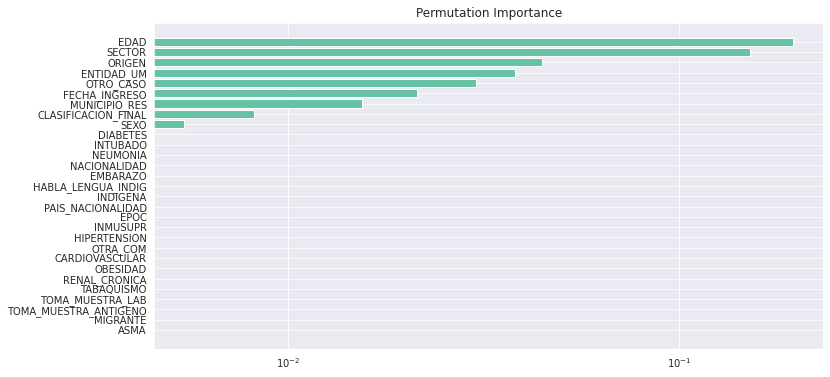

In [ ]:
fig = plt.figure(figsize=(12, 6))
plt.barh(range(len(sorted_idx)), perm_importance.importances_mean[sorted_idx], align='center', log=True)
plt.yticks(range(len(sorted_idx)), np.array(X_test.columns)[sorted_idx])
plt.title('Permutation Importance')

from the plot we can see that the only important features are 'EDAD', 'SECTOR', 'ORIGEN', 'ENTIDAD_UM', 'OTRO_CASO', 'FECHA_INGRESSO', 'MUNICIPIO_RES', 'CLASSIFICATION_FINAL', 'SEXO'

In [ ]:
df_fs = df[['EDAD', 'SECTOR', 'ORIGEN', 'ENTIDAD_UM', 'OTRO_CASO', 'FECHA_INGRESO', 'MUNICIPIO_RES', 'CLASIFICACION_FINAL', 'SEXO', 'TIPO_PACIENTE']]

In [ ]:
df_fs.to_csv(path + '/COVID2022_processed_feature_selection.csv')

# 4. Modelling

## Working with balanced dataset 
(target variable has equal number of examples)

-------
*functions*

In [3]:
def train_test(X_res, y_res, model):
    cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=3, random_state=1)
    scores = cross_validate(model, X_res, y_res, scoring=["roc_auc", "accuracy"], cv=cv, n_jobs=-1) 

    print('Mean ROC AUC: %.3f' % mean(scores['test_roc_auc']))
    print('Model accuracy score: %.3f' % mean(scores['test_accuracy']))
    
    y_pred = cross_val_predict(model, X_res, y_res, cv=5)
    
    mis = (y_res != y_pred).sum()
    print(f"Number of mislabeled points out of a total {X_res.shape[0]} points : {mis} ({round(mis/X_res.shape[0] * 100.00,2)}%)")
    
    cm = confusion_matrix(y_res, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='YlGnBu')
    plt.show()

In [4]:
def resample(X, y, majority, minitory):
    rus = RandomUnderSampler(sampling_strategy={0.0: majority , 1.0: minority})
    X_res, y_res = rus.fit_resample(X, y)
    print('Resampled dataset shape %s' % Counter(y_res))
    
    sm = BorderlineSMOTE(sampling_strategy='not majority')
    X_res, y_res = sm.fit_resample(X_res, y_res)
    print('Resampled dataset shape %s' % Counter(y_res))
    
    return X_res, y_res

------

#### Resampling datasets

In [9]:
df = pd.read_csv(path + '/COVID2022_processed.csv')
df_fs = pd.read_csv(path + '/COVID2022_processed_feature_selection.csv')
df_pca = pd.read_csv(path + '/COVID2022_processed_PCA.csv')

In [10]:
print(f"Data has {df.shape[0]} rows and {df.shape[1]} attributes")
print(f"Data has {df_fs.shape[0]} rows and {df_fs.shape[1]} attributes")
print(f"Data has {df_pca.shape[0]} rows and {df_pca.shape[1]} attributes")

Data has 1441909 rows and 31 attributes
Data has 1441909 rows and 11 attributes
Data has 1441909 rows and 7 attributes


In [11]:
df_s = df.sample(frac=0.3)

majority = int(0.2*len(df_s))
minority = len(df_s[df_s['TIPO_PACIENTE'] == 1.0])

X = df_s.copy()
y = X.pop('TIPO_PACIENTE')

X_res, y_res = resample(X, y, majority, minority)

Resampled dataset shape Counter({0.0: 86514, 1.0: 16464})
Resampled dataset shape Counter({0.0: 86514, 1.0: 86514})


In [12]:
#sanity check
#now the dataset is balanced (target variable has equal count of 0 and 1)
print(len(y_res[y_res == 1.0]))
print(len(y_res[y_res == 0.0]))

86514
86514


In [13]:
df_s = df_fs.sample(frac=0.3)

majority = int(0.2*len(df_s))
minority = len(df_s[df_s['TIPO_PACIENTE'] == 1.0])
               
X = df_s.copy()
y = X.pop('TIPO_PACIENTE')

X_res_fs, y_res_fs = resample(X, y, majority, minority)

Resampled dataset shape Counter({0.0: 86514, 1.0: 16453})
Resampled dataset shape Counter({0.0: 86514, 1.0: 86514})


In [14]:
df_s = df_pca.sample(frac=0.3)

majority = int(0.2*len(df_s))
minority = len(df_s[df_s['TIPO_PACIENTE'] == 1.0])
               
X = df_s.copy()
y = X.pop('TIPO_PACIENTE')

X_res_pca, y_res_pca = resample(X, y, majority, minority)

Resampled dataset shape Counter({0.0: 86514, 1.0: 16179})
Resampled dataset shape Counter({0.0: 86514, 1.0: 86514})


In [19]:
#To later put in the begginning, now can stay here
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV
from sklearn import metrics
from sklearn import tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV

#### **4.1 Nearest neighbor**

In [ ]:
model = KNeighborsClassifier(n_neighbors=3)

In k Nearest Neighbour case, more features leads to drastically increased computation time, so we will only test the model on PCA and FS sets. Also, first lets choose the starting point n_neighbours = 3 to confirm that model is working and later try to find a better value for it.

USING SELECTED FEATURES: 

Mean ROC AUC: 0.742
Model accuracy score: 0.696
Number of mislabeled points out of a total 173028 points : 51962 (30.03%)


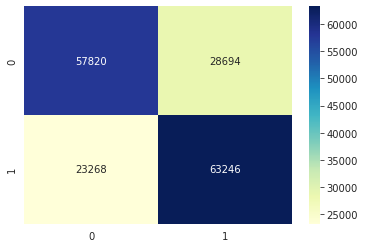

In [ ]:
print("USING SELECTED FEATURES: \n")
train_test(X_res_fs, y_res_fs, model)

USING PCA FEATURES: 

Mean ROC AUC: 0.747
Model accuracy score: 0.701
Number of mislabeled points out of a total 173028 points : 51005 (29.48%)


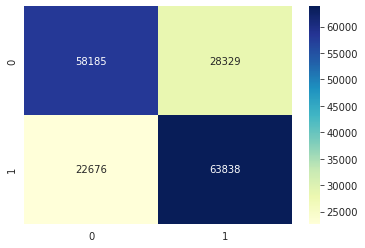

In [ ]:
print("USING PCA FEATURES: \n")
train_test(X_res_pca, y_res_pca, model)

We will use GridSearchCV to find the optimal value for n_neighbors:

In [ ]:
model2 = KNeighborsClassifier()
param_grid = {'n_neighbors': np.arange(1, 25)}
knn_gscv = GridSearchCV(model2, param_grid, cv=5)
knn_gscv.fit(X_res_fs, y_res_fs)

GridSearchCV(cv=5, estimator=KNeighborsClassifier(),
             param_grid={'n_neighbors': array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24])})

In [ ]:
#best performing n_neighbors value USING SELECTED FEATURES
knn_gscv.best_params_

{'n_neighbors': 9}

In [ ]:
model = KNeighborsClassifier(n_neighbors=9)

USING SELECTED FEATURES: 

Mean ROC AUC: 0.773
Model accuracy score: 0.711
Number of mislabeled points out of a total 173028 points : 49519 (28.62%)


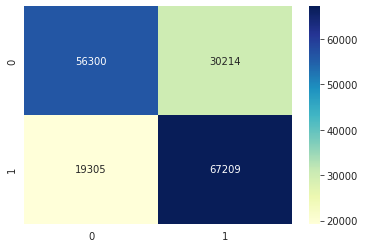

In [ ]:
print("USING SELECTED FEATURES: \n")
train_test(X_res_fs, y_res_fs, model)

In [ ]:
knn_gscv.fit(X_res_pca, y_res_pca)
#best performing n_neighbors value USING PCA FEATURES
knn_gscv.best_params_

{'n_neighbors': 9}

USING PCA FEATURES: 

Mean ROC AUC: 0.776
Model accuracy score: 0.714
Number of mislabeled points out of a total 173028 points : 48988 (28.31%)


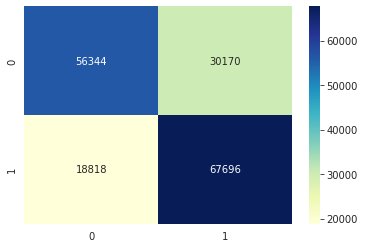

In [ ]:
print("USING PCA FEATURES: \n")
train_test(X_res_pca, y_res_pca, model)

https://towardsdatascience.com/building-a-k-nearest-neighbors-k-nn-model-with-scikit-learn-51209555453a#:~:text=Cross%2Dvalidation%20is%20when%20the,used%20as%20the%20test%20set.

#### **4.2 Bayesian Classifier**

Naive Bayes is a generative model that assumes that each class follow a Gaussian distribution.

In [ ]:
model = BernoulliNB()

USING ORIGINAL FEATURES: 

Mean ROC AUC: 0.801
Model accuracy score: 0.742
Number of mislabeled points out of a total 173028 points : 45341 (26.2%)


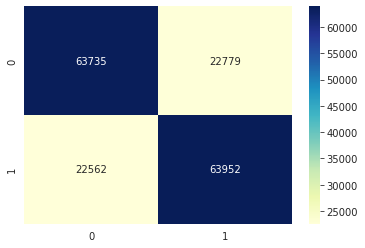

In [ ]:
print("USING ORIGINAL FEATURES: \n")
train_test(X_res, y_res, model)

USING SELECTED FEATURES: 

Mean ROC AUC: 0.800
Model accuracy score: 0.741
Number of mislabeled points out of a total 173028 points : 45632 (26.37%)


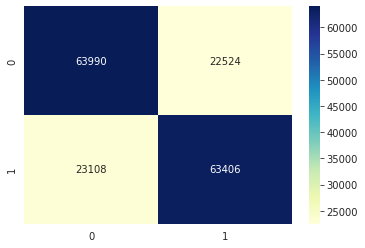

In [ ]:
print("USING SELECTED FEATURES: \n")
train_test(X_res_fs, y_res_fs, model)

USING PCA FEATURES: 

Mean ROC AUC: 0.775
Model accuracy score: 0.724
Number of mislabeled points out of a total 173028 points : 47831 (27.64%)


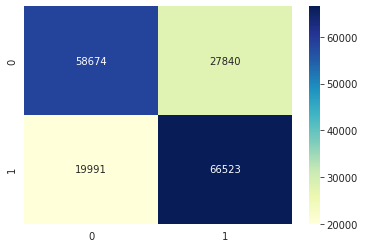

In [ ]:
print("USING PCA FEATURES: \n")
train_test(X_res_pca, y_res_pca, model)

#### **4.3 Decision Trees**

In [56]:
model = tree.DecisionTreeClassifier()

In [60]:
#one simple tree example
X_train, X_test, y_train, y_test = train_test_split(X_res, y_res, test_size=.33, shuffle=True, random_state=42)
model = model.fit(X_train, y_train)
y_pred = model.predict(X_test)
y_pred_train = model.predict(X_train)

print("ROC AUC:",metrics.roc_auc_score(y_test, y_pred))
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))
print("F1 score:",metrics.f1_score(y_test, y_pred))


ROC AUC: 0.9049324750230725
Accuracy: 0.904938704028021
F1 score: 0.9054948116164078


The results look great and all but it most likely is due to overfitting. 

In [61]:
print("Test Accuracy:",metrics.accuracy_score(y_test, y_pred))
print("Train Accuracy:",metrics.accuracy_score(y_train, y_pred_train))

Test Accuracy: 0.904938704028021
Train Accuracy: 1.0


Training accuracy is very high compared to the testing one, so indeed the model is overfitting. Let's have a look at some parameters.

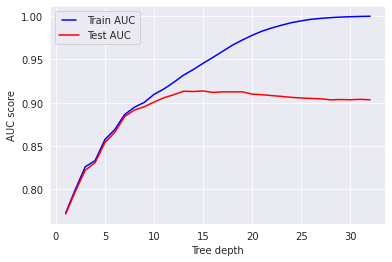

In [ ]:
max_depths = np.linspace(1, 32, 32, endpoint=True)
train_results = []
test_results = []
for max_depth in max_depths:
   dt = tree.DecisionTreeClassifier(max_depth=max_depth)
   dt.fit(X_train, y_train)

   train_pred = dt.predict(X_train)
   # Add auc score to previous train results
   train_results.append(metrics.roc_auc_score(y_train, train_pred))

   y_pred = dt.predict(X_test)
   # Add auc score to previous test results
   test_results.append(metrics.roc_auc_score(y_test, y_pred))

from matplotlib.legend_handler import HandlerLine2D
line1, = plt.plot(max_depths, train_results, 'b', label="Train AUC")
line2, = plt.plot(max_depths, test_results, 'r', label="Test AUC")
plt.legend(handler_map={line1: HandlerLine2D(numpoints=2)})
plt.ylabel("AUC score")
plt.xlabel("Tree depth")
plt.show()

#https://medium.com/@mohtedibf/indepth-parameter-tuning-for-decision-tree-6753118a03c3

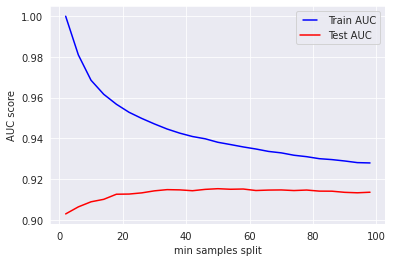

In [ ]:
min_samples_splits = np.arange(2, 101, 4).tolist()
train_results = []
test_results = []
for min_samples_split in min_samples_splits:
   dt = tree.DecisionTreeClassifier(min_samples_split=min_samples_split)
   dt.fit(X_train, y_train)

   train_pred = dt.predict(X_train)
   # Add auc score to previous train results
   train_results.append(metrics.roc_auc_score(y_train, train_pred))

   y_pred = dt.predict(X_test)
   # Add auc score to previous test results
   test_results.append(metrics.roc_auc_score(y_test, y_pred))

from matplotlib.legend_handler import HandlerLine2D
line1, = plt.plot(min_samples_splits, train_results, 'b', label="Train AUC")
line2, = plt.plot(min_samples_splits, test_results, 'r', label="Test AUC")
plt.legend(handler_map={line1: HandlerLine2D(numpoints=2)})
plt.ylabel("AUC score")
plt.xlabel("min samples split")
plt.show()

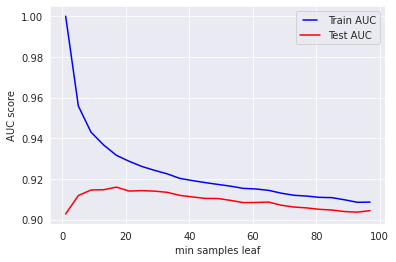

In [ ]:
min_samples_leafs = np.arange(1, 100, 4).tolist()
train_results = []
test_results = []
for min_samples_leaf in min_samples_leafs:
   dt = tree.DecisionTreeClassifier(min_samples_leaf=min_samples_leaf)
   dt.fit(X_train, y_train)

   train_pred = dt.predict(X_train)
   # Add auc score to previous train results
   train_results.append(metrics.roc_auc_score(y_train, train_pred))

   y_pred = dt.predict(X_test)
   # Add auc score to previous test results
   test_results.append(metrics.roc_auc_score(y_test, y_pred))

from matplotlib.legend_handler import HandlerLine2D
line1, = plt.plot(min_samples_leafs, train_results, 'b', label="Train AUC")
line2, = plt.plot(min_samples_leafs, test_results, 'r', label="Test AUC")
plt.legend(handler_map={line1: HandlerLine2D(numpoints=2)})
plt.ylabel("AUC score")
plt.xlabel("min samples leaf")
plt.show()

In [ ]:
from sklearn.model_selection import GridSearchCV

In [ ]:
#let's find the best combo knowing the information above
param_grid = {
    "max_depth": [5,10,11,12,13,14,15,20,None],
    "min_samples_split": [2,20,30,40],
    "min_samples_leaf": [5,10,15,20]
}

clf = tree.DecisionTreeClassifier(random_state=42)
grid_cv = GridSearchCV(clf, param_grid, scoring="roc_auc", n_jobs=-1, cv=3).fit(X_train, y_train)

print("Param for GS", grid_cv.best_params_)
print("CV score for GS", grid_cv.best_score_)
print("Train AUC ROC Score for GS: ", metrics.roc_auc_score(y_train, grid_cv.predict(X_train)))
print("Test AUC ROC Score for GS: ", metrics.roc_auc_score(y_test, grid_cv.predict(X_test)))

#https://towardsdatascience.com/3-techniques-to-avoid-overfitting-of-decision-trees-1e7d3d985a09

Param for GS {'max_depth': 14, 'min_samples_leaf': 20, 'min_samples_split': 2}
CV score for GS 0.9647277535890808
Train AUC ROC Score for GS:  0.9228318360066217
Test AUC ROC Score for GS:  0.9118384751546683


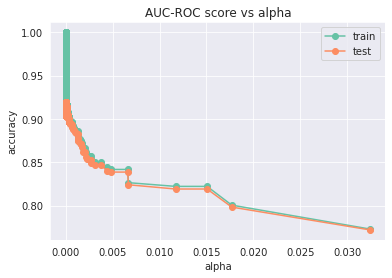

In [ ]:
#WARNING: takes long to run and probably is not necessary because there is no clear seperation and it best performs around 0

#post-pruning (CCP)
# Allow a decision tree to grow to its full depth
clf = tree.DecisionTreeClassifier(random_state=42)
clf.fit(X_train, y_train)

# compute ccp_alpha values
path = clf.cost_complexity_pruning_path(X_train, y_train)
ccp_alphas, impurities = path.ccp_alphas, path.impurities

# train DT classifier for each ccp_alpha value
clfs = []
for ccp_alpha in ccp_alphas:
    clf = tree.DecisionTreeClassifier(random_state=42, ccp_alpha=ccp_alpha)
    clf.fit(X_train, y_train)
    clfs.append(clf)

# Plot train and test score for each of the above trained model    
clfs = clfs[:-1]
ccp_alphas = ccp_alphas[:-1]

train_scores = [metrics.roc_auc_score(y_train, clf.predict(X_train)) for clf in clfs]
test_scores = [metrics.roc_auc_score(y_test, clf.predict(X_test)) for clf in clfs]

fig, ax = plt.subplots()
ax.set_xlabel("alpha")
ax.set_ylabel("accuracy")
ax.set_title("AUC-ROC score vs alpha")
ax.plot(ccp_alphas, train_scores, marker='o', label="train")
ax.plot(ccp_alphas, test_scores, marker='o', label="test")
ax.legend()
plt.show()

Let's check for smaller alpha values:

In [43]:
#post-pruning (CCP)
# Allow a decision tree to grow to its full depth
clf = tree.DecisionTreeClassifier(random_state=42)
clf.fit(X_train, y_train)

# compute ccp_alpha values
path = clf.cost_complexity_pruning_path(X_train, y_train)
ccp_alphas, impurities = path.ccp_alphas, path.impurities

In [44]:
ccp_alphas.sort()
ccp_alphas.size

3877

In [47]:
ccp_small = []
for ccp_alpha in ccp_alphas:
  if ccp_alpha > 0.0001: break
  ccp_small.append(ccp_alpha)

len(ccp_small)

3741

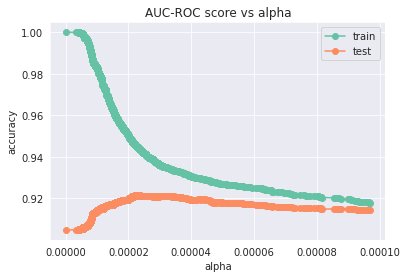

In [48]:
#WARNING: long runtime ( > 1h)
# train DT classifier for each ccp_alpha value
clfs = []
for ccp_alpha in ccp_small:
    clf = tree.DecisionTreeClassifier(random_state=42, ccp_alpha=ccp_alpha)
    clf.fit(X_train, y_train)
    clfs.append(clf)

# Plot train and test score for each of the above trained model    
clfs = clfs[:-1]
ccp_alphas = ccp_small[:-1]

train_scores = [metrics.roc_auc_score(y_train, clf.predict(X_train)) for clf in clfs]
test_scores = [metrics.roc_auc_score(y_test, clf.predict(X_test)) for clf in clfs]

fig, ax = plt.subplots()
ax.set_xlabel("alpha")
ax.set_ylabel("accuracy")
ax.set_title("AUC-ROC score vs alpha")
ax.plot(ccp_alphas, train_scores, marker='o', label="train")
ax.plot(ccp_alphas, test_scores, marker='o', label="test")
ax.legend()
plt.show()

In [49]:
max(test_scores)

0.9216887605160948

In [50]:
max_y = max(test_scores)  # Find the maximum y value
max_x = ccp_alphas[test_scores.index(max_y)]  # Find the x value corresponding to the maximum y value
print(max_x, max_y)

2.2636058084769204e-05 0.9216887605160948


So visually the best ccp_alpha value is between 0.00002 and 0.00004. To be precise looking from test score, 2.2636058084769204e-05

In [63]:
#let's check with the tuned parameters
model = tree.DecisionTreeClassifier(max_depth=14,min_samples_split=2,min_samples_leaf=20)
model = model.fit(X_train, y_train)
y_pred = model.predict(X_test)
y_pred_train = model.predict(X_train)
print("Test Accuracy:",metrics.accuracy_score(y_test, y_pred))
print("Train Accuracy:",metrics.accuracy_score(y_train, y_pred_train))

Test Accuracy: 0.9152189141856393
Train Accuracy: 0.9247636464012146


This is better, not a big difference between Test and Train predictions.

USING ORIGINAL FEATURES: 

Mean ROC AUC: 0.968
Model accuracy score: 0.913
Number of mislabeled points out of a total 173028 points : 19970 (11.54%)


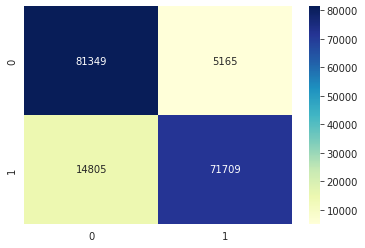

In [ ]:
print("USING ORIGINAL FEATURES: \n")
train_test(X_res, y_res, model)

USING SELECTED FEATURES: 

Mean ROC AUC: 0.969
Model accuracy score: 0.914
Number of mislabeled points out of a total 173028 points : 19558 (11.3%)


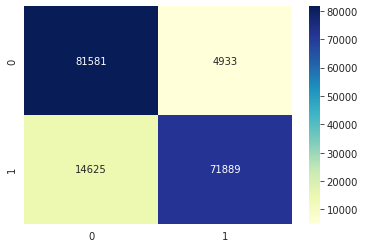

In [ ]:
print("USING SELECTED FEATURES: \n")
train_test(X_res_fs, y_res_fs, model)

USING PCA FEATURES: 

Mean ROC AUC: 0.948
Model accuracy score: 0.879
Number of mislabeled points out of a total 173028 points : 23667 (13.68%)


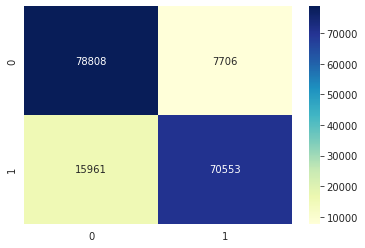

In [ ]:
print("USING PCA FEATURES: \n")
train_test(X_res_pca, y_res_pca, model)

**This is still such good result wtf I did not expect this from decision trees??? So there is a chance I did something wrong:)))**

#### **4.4 Tree ensembles**

#### Random Forest

In [16]:
model = RandomForestClassifier()

In [20]:
X_train, X_test, y_train, y_test = train_test_split(X_res, y_res, test_size=.33, shuffle=True, random_state=42)
model = model.fit(X_train, y_train)
y_pred = model.predict(X_test)
y_pred_train = model.predict(X_train)

print("Test Accuracy:",metrics.accuracy_score(y_test, y_pred))
print("Train Accuracy:",metrics.accuracy_score(y_train, y_pred_train))

Test Accuracy: 0.9355341506129597
Train Accuracy: 0.9999741218687461


Training accuracy is very high compared to the testing one, therefore the model is overfitting. Also the model considers feature importance too.

In [ ]:
pd.DataFrame(model.feature_importances_, index=X_train.columns).sort_values(by=0, ascending=False)

In random forests, there is no need for cross-validation or a separate test set to get an unbiased estimate of the test set error. It is estimated internally, during the run [[source]](https://www.stat.berkeley.edu/~breiman/RandomForests/cc_home.htm#:~:text=In%20random%20forests%2C%20there%20is,sample%20from%20the%20original%20data.)

In [21]:
#Tuning the parameters
#https://towardsdatascience.com/a-practical-guide-to-implementing-a-random-forest-classifier-in-python-979988d8a263
# Number of trees in random forest
n_estimators = [100, 200, 300, 400] #np.linspace(100, 3000, int((3000-100)/200) + 1, dtype=int)
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Criterion
criterion=['gini', 'entropy']

#From decision trees exploration, let's decide that:
max_depth= [14]
min_samples_split= [2]
min_samples_leaf= [20]

random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'bootstrap': bootstrap,
               'criterion': criterion,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf}

For faster computation, this time let's use RandomizedSearchCV

In [ ]:
rf_base = RandomForestClassifier()
rf_random = RandomizedSearchCV(estimator = rf_base,
                               param_distributions = random_grid,
                               n_iter = 30, cv = 5,
                               verbose=2,
                               random_state=42, n_jobs = 4)
rf_random.fit(X_train, y_train)

Fitting 5 folds for each of 30 candidates, totalling 150 fits


In [ ]:
rf_random.best_params_

In [84]:
model = RandomForestClassifier(max_depth=14,min_samples_split=2,min_samples_leaf=20)
X_train, X_test, y_train, y_test = train_test_split(X_res, y_res, test_size=.33, shuffle=True, random_state=42)
model = model.fit(X_train, y_train)
y_pred = model.predict(X_test)
y_pred_train = model.predict(X_train)

print("Test Accuracy:",metrics.accuracy_score(y_test, y_pred))
print("Train Accuracy:",metrics.accuracy_score(y_train, y_pred_train))

Test Accuracy: 0.9174956217162872
Train Accuracy: 0.9241684493823753


The difference between Test and Train predictions is not as big anymore, so the model is not overfitting as much.

Number of mislabeled points out of a total 57100 points : 4711 (8.25%)


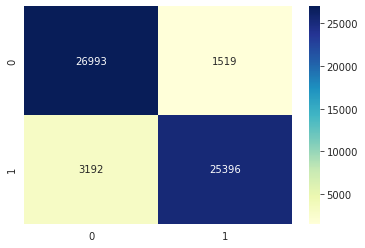

In [88]:
mis = (y_test != y_pred).sum()
print(f"Number of mislabeled points out of a total {y_test.shape[0]} points : {mis} ({round(mis/y_test.shape[0] * 100.00,2)}%)")   
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='YlGnBu')
plt.show()

#### **4.5 Support Vector Machines**

#### **4.5 Neural Network Classifier**

#### **4.6 Comparison**

## Working with imbalanced data
Since most of the machine learning algorithms used for classification were designed around the assumption of an equal number of examples for each class, it may result in models that have poor predictive performance, specifically for the minority class [[source]](https://machinelearningmastery.com/what-is-imbalanced-classification/). This is a problem because, in our case, the minority class (likely to die) is more important and therefore the problem is more sensitive to classification errors for the minority class than the majority class
